In [122]:
%pip install seaborn


   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   -------- ------------------------------- 61.4/294.9 kB 1.1 MB/s eta 0:00:01
   -------------------------- ------------- 194.6/294.9 kB 2.4 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 2.6 MB/s eta 0:00:00


In [123]:
import random
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import PDSVRP_instance
from importnb import Notebook
import copy
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.tree import export_graphviz
import graphviz
import seaborn as sns


with Notebook():
    import heuristic as h
    import utilities as u

In [152]:
# Parameter ranges
param_ranges = {
    'num_customers': (10, 100),
    'grid_size': (20, 40),
    'num_drones': (1, 20),
    'battery_endurance': (0.25, 1.0),  # in hours
    'cost_ratio': (10.0, 50.0)
}

# Constants
constants = {
    'truck_speed': 30.0,
    'drone_speed': 40.0,
    'truck_capacity': 1300.0,
    'drone_capacity': 2.27,
    'drone_unit_cost': 0.03,
    'work_time_limit': 8.0
}

num_instances = 100

In [153]:
def generate_instance(num_custumers, grid_size, num_drones, battery_endurance, cost_ratio):
    custumers = []
    
    depot = [{
        'x': grid_size/2,
        'y': grid_size/2, 
        'demand': 0.00
    }]
    
    custumers = [
            {
                'x': random.uniform(0, param_ranges['grid_size'][1]),
                'y': random.uniform(0, param_ranges['grid_size'][1]),
                'demand': random.uniform(0, 3) if np.random.rand() < 0.6 else random.uniform(5, 50) 
            }
            for _ in range(num_custumers)
        ]
    
    all_entities  = depot + custumers
    
    header = (
        f"NUM DRONES,{num_drones}\n"
        f"NUM TRUCKS,{10}\n"
        f"TRUCK CAP,{constants['truck_capacity']}\n"
        f"DRONE CAP,{constants['drone_capacity']}\n"
        f"TRUCK SPEED,{constants['truck_speed']}\n"
        f"DRONE SPEED,{constants['drone_speed']}\n"
        f"DRONE ENDURANCE,{battery_endurance:.2f}\n"
        f"DRONE TIME LIMIT,{random.uniform(1.0, constants['work_time_limit']):.2f}\n"
        f"TRUCK TIME LIMIT,{random.uniform(1.0, constants['work_time_limit']):.2f}\n"
        f"TRUCK UNIT COST,{cost_ratio * constants['drone_unit_cost']:.2f}\n"
        f"DRONE UNIT COST,{constants['drone_unit_cost']}\n"
    )
    customer_lines = "\n".join(
        f"{i}\t{customer['x']:.2f}\t{customer['y']:.2f}\t{customer['demand']:.2f}"
        for i, customer in enumerate(all_entities)
    )
    return header + customer_lines

In [154]:
instances = []
params = []

for _ in range(num_instances):
    int_params = {
        'num_custumers': random.randint(*param_ranges['num_customers']),
        'grid_size': random.randint(*param_ranges['grid_size']),
        'num_drones': random.randint(*param_ranges['num_drones']),
        'battery_endurance': random.uniform(*param_ranges['battery_endurance']),
        'cost_ratio': random.uniform(*param_ranges['cost_ratio']),
    }
    params.append(int_params)
    instances.append(generate_instance(int_params['num_custumers'], int_params['grid_size'], int_params['num_drones'], int_params['battery_endurance'], int_params['cost_ratio']))

df = pd.DataFrame(params)

In [155]:
for index, instance in enumerate(instances):
    with open('./generated_instances/'+ str(index) + '-r-r' '.txt', 'w') as file:
        file.write(str(instance))

In [156]:
def compute_cost_saving(instance_name, sigma, c_average_removed, L_max, w1, w2, w3, w4, w5, gamma, n_nearest, delta, epsilon, iter_imp, iter_max, p_min, p_max, max_unfeasible_swaps_perturb):
    instance = PDSVRP_instance.PDSVRPInstance("generated_instances/" + instance_name)
    
    instance_no_drones = copy.deepcopy(instance)
    instance_no_drones.D = 0
        
    sol_drones = h.SISSRs(instance, sigma, c_average_removed, L_max, w1, w2, w3, w4, w5, gamma, n_nearest, delta, epsilon, iter_imp, iter_max, p_min, p_max, max_unfeasible_swaps_perturb)
    sol_no_drones = h.SISSRs(instance_no_drones, sigma, c_average_removed, L_max, w1, w2, w3, w4, w5, gamma, n_nearest, delta, epsilon, iter_imp, iter_max, p_min, p_max, max_unfeasible_swaps_perturb)
    
    cost_with_drones = u.cost(instance, sol_drones)
    cost_without_drones = u.cost(instance_no_drones, sol_no_drones)
    
    cost_saving = 100 * (cost_without_drones - cost_with_drones) / cost_without_drones
    return cost_saving

In [92]:
#compute_cost_saving("9-r-r.txt", 0.3, 4.5, 4.5, 5,1,1,2,2, 0.1, 20, 0.1, 0.999975, 100, 100, 3, 3, 9)

In [158]:
# Apply the function to each instance
cost_savings = []

instances_name_files = []
for index in range(num_instances):
    instances_name_files.append(str(index) + "-r-r.txt")
            
for name_file_instance in instances_name_files:
    cost_savings.append(compute_cost_saving(name_file_instance, 0.3, 4.5, 4.5, 5,1,1,2,2, 0.1, 20, 0.1, 0.999975, 100, 100, 3, 3, 9))
    
df['cost_savings'] = cost_savings

Iteration:  1
Costo miglior soluzione:  287.52277095597765
Iteration:  2
Costo miglior soluzione:  287.52277095597765
Iteration:  3
Costo miglior soluzione:  287.52277095597765
Iteration:  4
Costo miglior soluzione:  287.52277095597765
Iteration:  5
Costo miglior soluzione:  287.52277095597765
Iteration:  6
Costo miglior soluzione:  287.52277095597765
Iteration:  7
Costo miglior soluzione:  287.52277095597765
Iteration:  8
Costo miglior soluzione:  287.52277095597765
Iteration:  9
Costo miglior soluzione:  287.52277095597765
Iteration:  10
Costo miglior soluzione:  287.52277095597765
Iteration:  11
Costo miglior soluzione:  287.52277095597765
Iteration:  12
Costo miglior soluzione:  287.52277095597765
Iteration:  13
Costo miglior soluzione:  287.52277095597765
Iteration:  14
Costo miglior soluzione:  287.52277095597765
Iteration:  15
Costo miglior soluzione:  287.52277095597765
Iteration:  16
Costo miglior soluzione:  287.52277095597765
Iteration:  17
Costo miglior soluzione:  287.5227

In [159]:
df.to_csv("results/sensitivity_analysis_results.csv")
df

,num_custumers,grid_size,num_drones,battery_endurance,cost_ratio,cost_savings
0,54,22,3,0.888418,30.635681,12.800471
1,47,37,9,0.343970,48.130362,-8.837392
2,10,37,1,0.892297,49.216407,0.000000
3,39,38,10,0.290462,19.423496,-5.706702
4,73,33,14,0.675686,37.469947,0.257147
...,...,...,...,...,...,...
95,61,38,10,0.536539,33.434309,1.388548
96,54,24,12,0.876179,23.649363,9.331165
97,14,26,20,0.469073,43.961862,0.000000
98,77,33,17,0.729374,22.546082,3.743749


In [174]:
# Features
X = df[['num_custumers', 'grid_size', 'num_drones', 'battery_endurance', 'cost_ratio']]

# Target
y = df['cost_savings']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
regressor = DecisionTreeRegressor(max_depth=5, min_samples_leaf=10, random_state=42)

regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 20.212147444194983


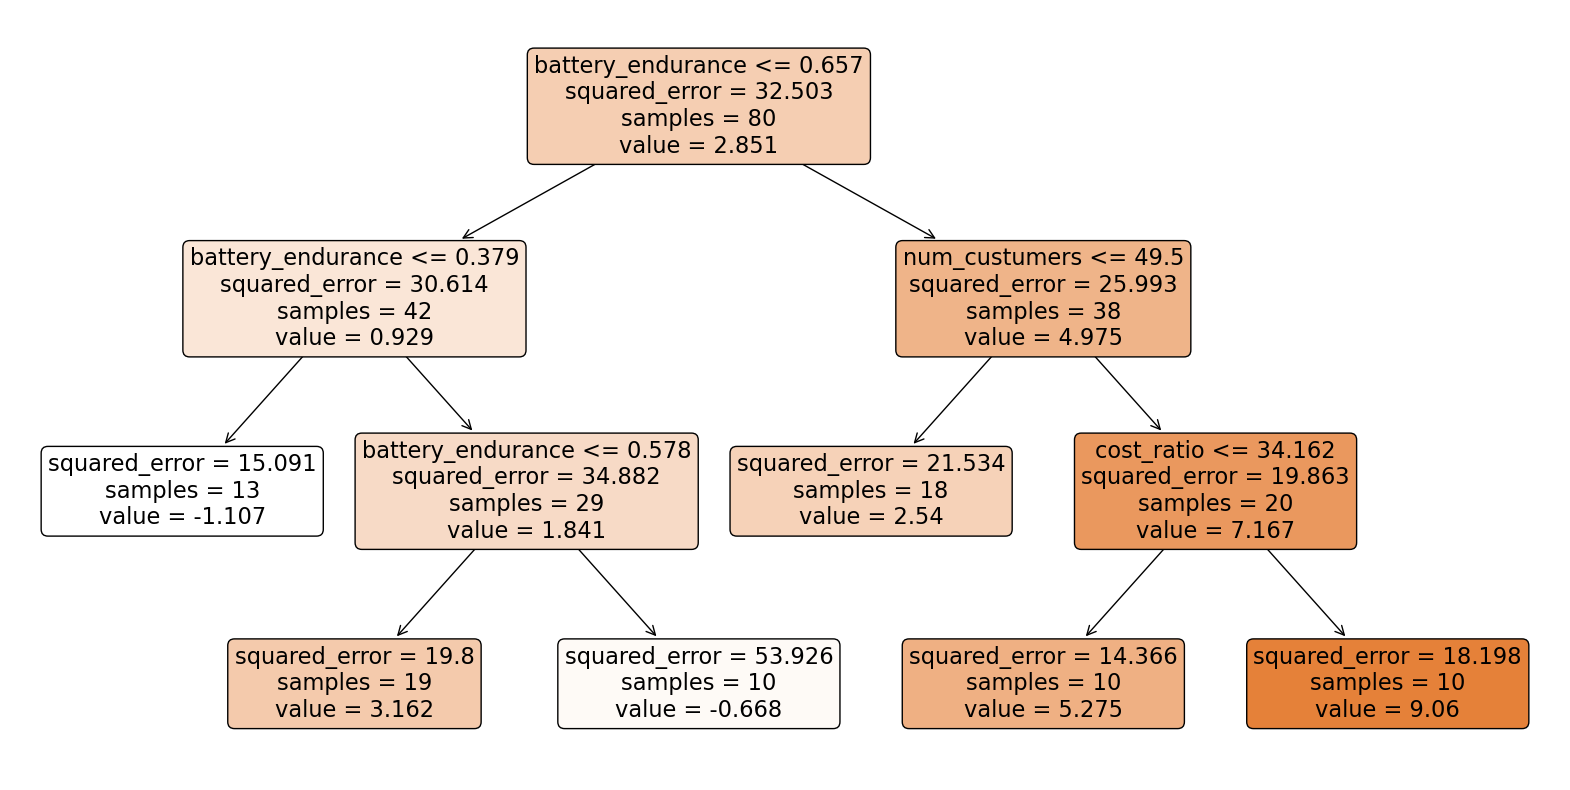

In [175]:
plt.figure(figsize=(20,10))
plot_tree(regressor, feature_names=X.columns, filled=True, rounded=True)
plt.show()

[0.26166777 0.         0.         0.64596061 0.09237162]
       num_custumers   grid_size  num_drones  battery_endurance  cost_ratio
count      100.00000  100.000000  100.000000         100.000000  100.000000
mean        52.74000   29.760000   11.150000           0.645149   30.094529
std         26.94312    5.930779    5.636058           0.212801   12.681079
min         10.00000   20.000000    1.000000           0.259887   10.050327
25%         30.75000   25.000000    7.000000           0.468048   19.292088
50%         52.00000   30.000000   11.000000           0.643669   30.273547
75%         78.00000   35.000000   16.250000           0.835356   41.124877
max         98.00000   40.000000   20.000000           0.996912   49.793729
count    100.000000
mean       2.994875
std        5.361605
min      -18.436346
25%        0.103547
50%        2.784663
75%        5.831545
max       17.416248
Name: cost_savings, dtype: float64
{'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': 5,

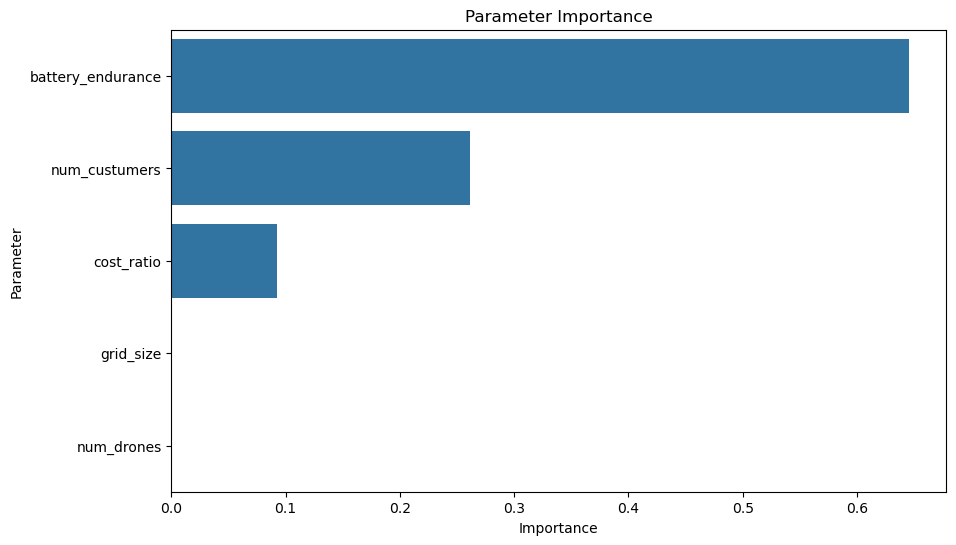

In [171]:
# Retrieve the feature importances
feature_importances = regressor.feature_importances_
print(feature_importances)

print(X.describe())
print(y.describe())
print(regressor.get_params())


# Create a dataframe for better visualization
importance_df = pd.DataFrame({
    'Parameter': X.columns,
    'Importance': feature_importances
})

# Normalize the importance values
importance_df['Importance'] = importance_df['Importance'] / importance_df['Importance'].sum()

# Sort the dataframe by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the dataframe
print(importance_df)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Parameter')
plt.title('Parameter Importance')
plt.show()